**Ex 10**

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1 completed


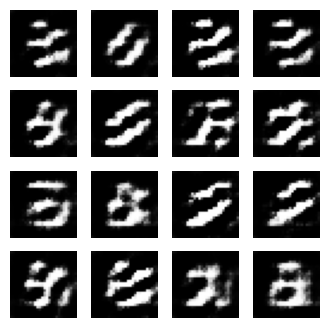

Epoch 2 completed


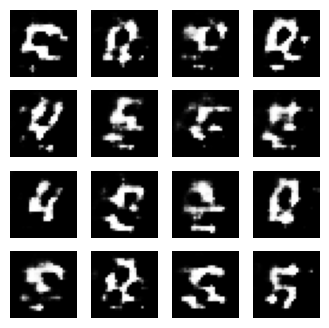

Epoch 3 completed


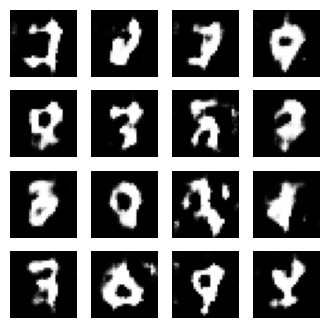

Epoch 4 completed


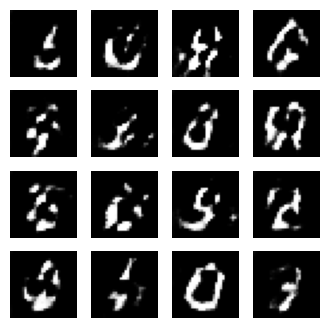

Epoch 5 completed


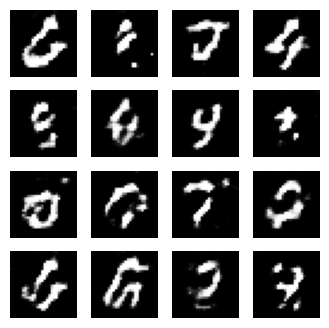

Epoch 6 completed


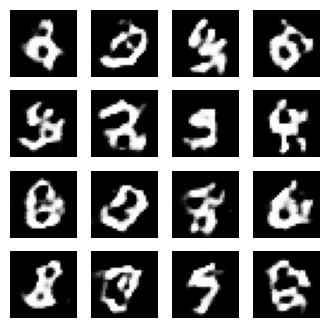

Epoch 7 completed


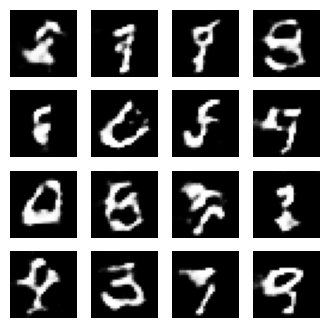

Epoch 8 completed


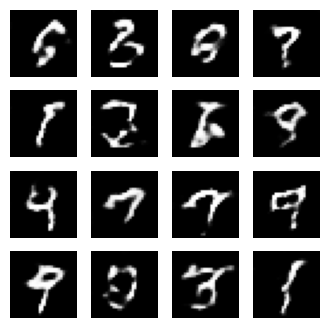

Epoch 9 completed


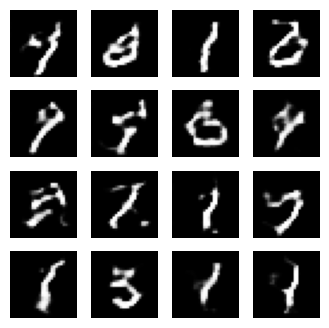

Epoch 10 completed


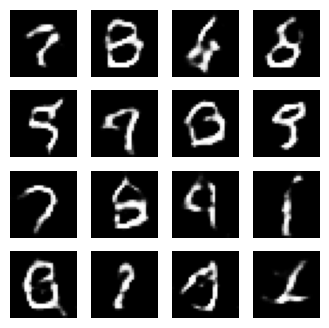

Epoch 11 completed


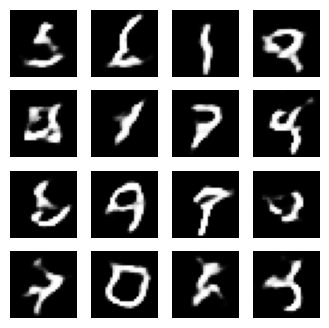

Epoch 12 completed


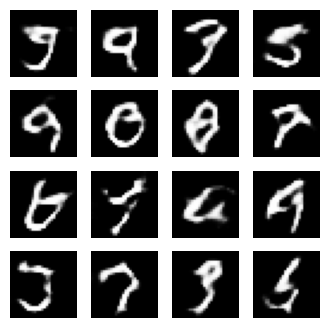

Epoch 13 completed


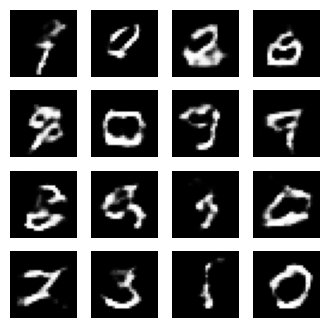

Epoch 14 completed


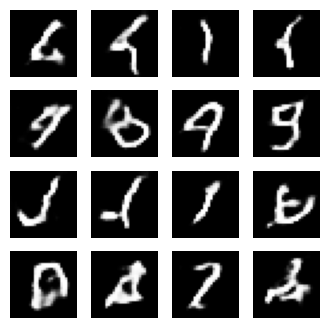

Epoch 15 completed


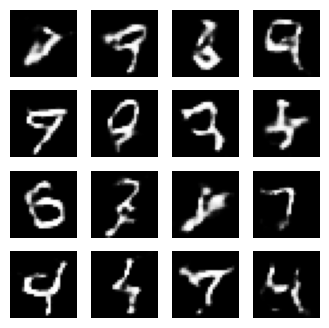

Epoch 16 completed


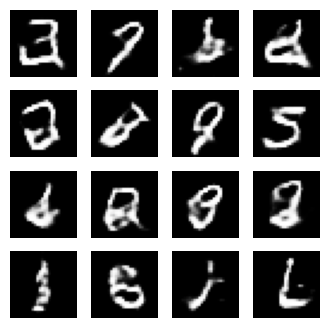

Epoch 17 completed


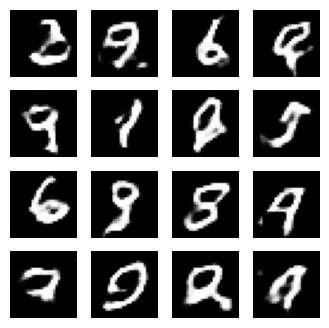

Epoch 18 completed


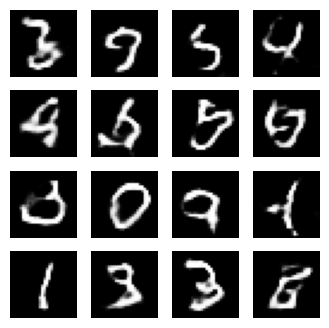

Epoch 19 completed


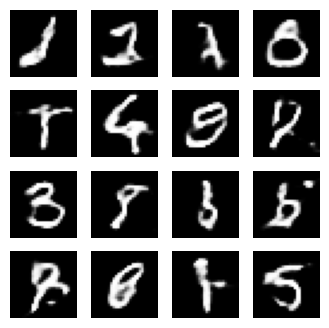

Epoch 20 completed


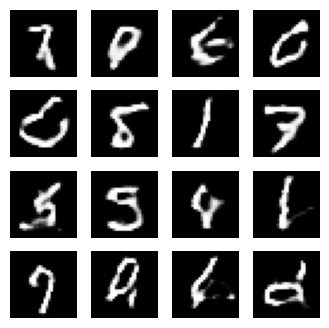

Epoch 21 completed


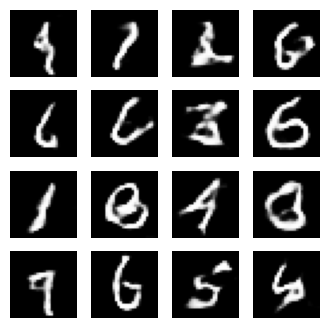

Epoch 22 completed


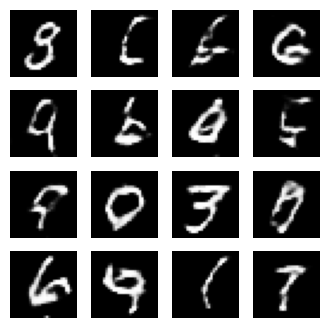

Epoch 23 completed


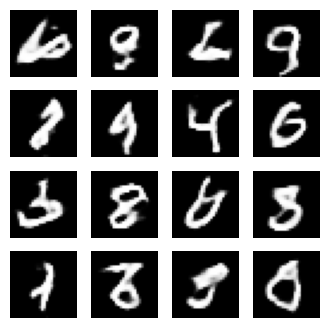

Epoch 24 completed


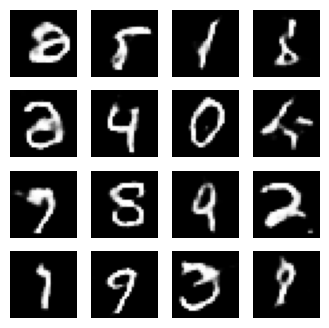

Epoch 25 completed


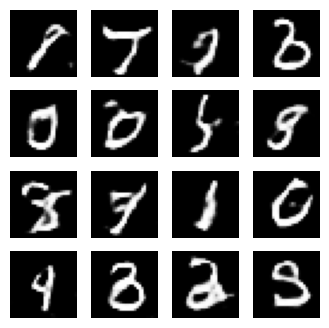

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Load and preprocess data: [-1, 1] scaling
(x_train, _), _ = tf.keras.datasets.mnist.load_data()
x_train = (x_train - 127.5) / 127.5
x_train = x_train[..., tf.newaxis].astype('float32')  # (28, 28, 1)

BUFFER_SIZE = 60000
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Generator using Conv2DTranspose
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

# Discriminator using Conv2D
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5,5), strides=(2,2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

generator = build_generator()
discriminator = build_discriminator()

# Loss and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
gen_optimizer = tf.keras.optimizers.Adam(1e-4)
disc_optimizer = tf.keras.optimizers.Adam(1e-4)

# Training step
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated, training=True)

        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        disc_loss = (cross_entropy(tf.ones_like(real_output), real_output) +
                     cross_entropy(tf.zeros_like(fake_output), fake_output))

    gen_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))

# Generate and show sample images
def generate_and_plot():
    noise = tf.random.normal([16, 100])
    predictions = generator(noise, training=False)

    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, 0] + 1) / 2, cmap='gray')
        plt.axis('off')
    plt.show()

# Training loop
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)
        print(f"Epoch {epoch+1} completed")
        generate_and_plot()

# Start training (10 epochs for quick results)
train(train_dataset, epochs=25)